In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras as keras
from statistics import mean


data = pd.read_csv("data/Stocks/aapl.us.txt")

In [2]:
data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
...,...,...,...,...,...,...,...
8359,2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0
8360,2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0
8361,2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0
8362,2017-11-09,174.48000,175.46000,172.52000,175.25000,29533086,0


In [3]:
#split to training (60%), validation(20%) and test data(20%)
train_data,val_data, test_data = data[0:int(len(data)*0.60)],data[int(len(data)*0.60):int(len(data)*0.80)],data[int(len(data)*0.80):len(data)]

In [4]:
val_data

,Date,Open,High,Low,Close,Volume,OpenInt
5018,2004-08-02,2.0003,2.0618,1.9926,2.0221,101816881,0
5019,2004-08-03,2.0171,2.0312,1.9939,2.0030,59018788,0
5020,2004-08-04,1.9977,2.0567,1.9965,2.0350,77107901,0
5021,2004-08-05,2.0337,2.0682,2.0003,2.0106,68186131,0
5022,2004-08-06,1.9787,1.9914,1.9018,1.9070,137290881,0
...,...,...,...,...,...,...,...
6686,2011-03-16,43.7760,43.9270,41.7830,42.2610,321588398,0
6687,2011-03-17,43.1480,43.4920,42.3460,42.8540,183661658,0
6688,2011-03-18,43.1420,43.3080,42.2600,42.3460,209933174,0
6689,2011-03-21,43.0460,43.5090,42.9340,43.4520,115188315,0


In [5]:
training_set = train_data.iloc[:,4:5]
val_set = val_data.iloc[:,4:5]

In [6]:
#normalise training and validation dataset for training
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_val_set = scaler.fit_transform(val_set)

In [7]:
scaled_training_set

array([[0.0440861 ],
       [0.04350701],
       [0.04525796],
       ...,
       [0.41869823],
       [0.42391916],
       [0.41956459]])

In [8]:
#prepare trainging and validation data
x_train = []
y_train = []
timestamp = 60

for i in range(timestamp,len(training_set)):
    x_train.append(scaled_training_set[i-timestamp:i,0])
    y_train.append(scaled_training_set[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(timestamp,len(val_set)):
    x_val.append(scaled_val_set[i-timestamp:i,0])
    y_val.append(scaled_val_set[i,0])
    
x_val = np.array(x_val)
y_val = np.array(y_val)

#reshape data for lstm training
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)

In [9]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(4958, 60, 1) (4958,)
(1613, 60, 1) (1613,)


In [10]:
def LSTM_model():
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 35, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 35))
    model.add(keras.layers.Dense(units = 35))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val), verbose = 0)
    return model,history


In [11]:
model,history = LSTM_model()

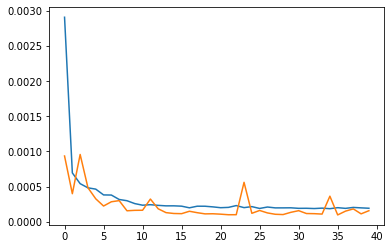

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [13]:
#normalising test data for prediction
data_test = pd.concat((val_data["Close"], test_data["Close"]), axis = 0,ignore_index = True)
inputs = data_test[(len(data_test) - len(test_data) - timestamp):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.fit_transform(inputs)

#prepare test data
x_test = []
y_test = []

for i in range(timestamp,len(test_data) + timestamp):
    x_test.append(inputs[i-timestamp:i,0])
    y_test.append(inputs[i,0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [14]:
#prediction for test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

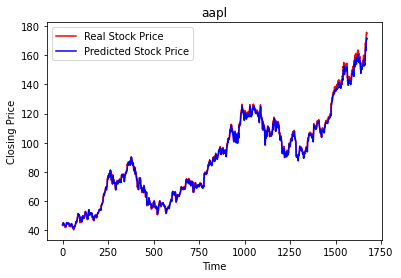

In [15]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('aapl')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [16]:
mean_squared_error(y_test,y_pred)

3.0979915213083076

In [17]:
#investigate the effect of early stopping using val_loss
def LSTM_model_early(tolerant):
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 35, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 35))
    model.add(keras.layers.Dense(units = 35))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=tolerant)
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val),callbacks=[callback], verbose = 0)
    return model,history



In [18]:
def trial():
    full,early,loss1,loss2 = [],[],[],[]
    for i in range(10):
        
        model,history = LSTM_model()
        min_full = history.history['val_loss'][-1]
        min_loss1 = history.history['loss'][-1]
        full.append(min_full)
        loss1.append(min_loss1)
    
        model_early,history_early = LSTM_model_early(5)
        min_early = history_early.history['val_loss'][-1]
        min_loss_e = history_early.history['loss'][-1]
        early.append(min_early)
        loss2.append(min_loss_e)
        
        print(i)
    
    avg_full = mean(full)
    avg_early = mean(early)
    avg_loss1 = mean(loss1)
    avg_loss2 = mean(loss2)
    print(avg_full,avg_early)
    print(avg_loss1,avg_loss2)

In [19]:
trial()

0
1
2
3
4
5
6
7
8
9
0.00015690277723479085 0.00023612453151145019
0.00019054845033679159 0.00022059564216760918


The difference between training with early stopping and no early stopping for both training loss and validation loss are very small, but early stopping is able to save a significant amount of time for training and grid search.

#grid search done in another notebook

suggested parameter:
timestep = 55
nodes = 45

In [22]:
x_train = []
y_train = []
timestamp = 55

for i in range(timestamp,len(training_set)):
    x_train.append(scaled_training_set[i-timestamp:i,0])
    y_train.append(scaled_training_set[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(timestamp,len(val_set)):
    x_val.append(scaled_val_set[i-timestamp:i,0])
    y_val.append(scaled_val_set[i,0])
    
x_val = np.array(x_val)
y_val = np.array(y_val)

#reshape data for lstm training
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)

def LSTM_model_GS():
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 45, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 45))
    model.add(keras.layers.Dense(units = 45))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val),callbacks=[callback], verbose = 0)
    return model,history

In [23]:
model,history = LSTM_model_GS()

In [24]:
#normalising test data for prediction
data_test = pd.concat((val_data["Close"], test_data["Close"]), axis = 0,ignore_index = True)
inputs = data_test[(len(data_test) - len(test_data) - timestamp):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.fit_transform(inputs)

#prepare test data
x_test = []
y_test = []

for i in range(timestamp,len(test_data) + timestamp):
    x_test.append(inputs[i-timestamp:i,0])
    y_test.append(inputs[i,0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

#prediction for test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

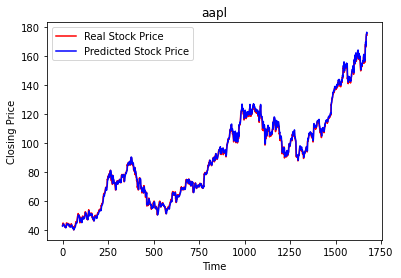

In [25]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('aapl')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [26]:
mean_squared_error(y_test,y_pred)

2.4212485985780967